# Component -> Circuit -> Mask

gdsfactory easily enables you to go from a Component, to a higher level Component (circuit), or even higher level Component (Mask)

For a component it's important that you spend some time early to parametrize it correctly. Don't be afraid to spend some time using pen and paper and choosing easy to understand names.

Lets for example define a ring resontator. A ring resonator is already a circuit made of waveguides, bends and couplers.


## Component

You can define any new Component define as a function that returns a component

2022-03-03 06:45:37.222 | INFO     | gdsfactory.config:<module>:52 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 4.3.0


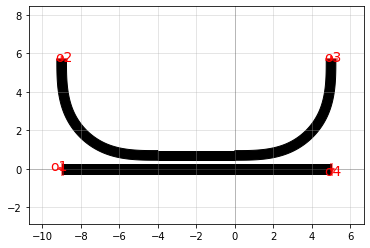

In [1]:
from typing import Optional

import gdsfactory as gf
from gdsfactory.component import Component
from gdsfactory.components.bend_euler import bend_euler
from gdsfactory.components.coupler90 import coupler90 as coupler90function
from gdsfactory.components.coupler_straight import (
    coupler_straight as coupler_straight_function,
)
from gdsfactory.cross_section import strip
from gdsfactory.snap import assert_on_2nm_grid
from gdsfactory.types import ComponentFactory, CrossSectionFactory


@gf.cell
def coupler_ring(
    gap: float = 0.2,
    radius: float = 5.0,
    length_x: float = 4.0,
    coupler90: ComponentFactory = coupler90function,
    bend: Optional[ComponentFactory] = None,
    coupler_straight: ComponentFactory = coupler_straight_function,
    cross_section: CrossSectionFactory = strip,
    **kwargs
) -> Component:
    r"""Coupler for ring.

    Args:
        gap: spacing between parallel coupled straight waveguides.
        radius: of the bends.
        length_x: length of the parallel coupled straight waveguides.
        coupler90: straight coupled to a 90deg bend.
        straight: library for straight waveguides.
        bend: library for bend
        coupler_straight: two parallel coupled straight waveguides.
        cross_section:
        kwargs: cross_section settings

    .. code::

           2             3
           |             |
            \           /
             \         /
           ---=========---
         1    length_x    4


    """
    bend = bend or bend_euler

    c = Component()
    assert_on_2nm_grid(gap)

    # define subcells
    coupler90_component = (
        coupler90(
            gap=gap, radius=radius, bend=bend, cross_section=cross_section, **kwargs
        )
        if callable(coupler90)
        else coupler90
    )
    coupler_straight_component = (
        coupler_straight(
            gap=gap, length=length_x, cross_section=cross_section, **kwargs
        )
        if callable(coupler_straight)
        else coupler_straight
    )

    # add references to subcells
    cbl = c << coupler90_component
    cbr = c << coupler90_component
    cs = c << coupler_straight_component

    # connect references
    y = coupler90_component.y
    cs.connect(port="o4", destination=cbr.ports["o1"])
    cbl.reflect(p1=(0, y), p2=(1, y))
    cbl.connect(port="o2", destination=cs.ports["o2"])

    c.absorb(cbl)
    c.absorb(cbr)
    c.absorb(cs)

    c.add_port("o1", port=cbl.ports["o3"])
    c.add_port("o2", port=cbl.ports["o4"])
    c.add_port("o3", port=cbr.ports["o3"])
    c.add_port("o4", port=cbr.ports["o4"])
    c.auto_rename_ports()
    return c


coupler = coupler_ring(cache=False)
coupler.plot()

## Circuits

You can define a circuit also with a function, and some of the parameters can also be functions that returns other components

For example, lets define a ring function that also accepts other component functions (straight, coupler, bend)


### Circuit function

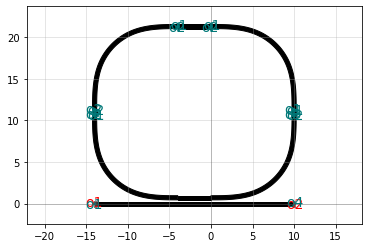

In [2]:
import gdsfactory as gf


@gf.cell
def ring_single(
    gap: float = 0.2,
    radius: float = 10.0,
    length_x: float = 4.0,
    length_y: float = 0.6,
    coupler_ring: gf.types.ComponentFactory = coupler_ring,
    straight: gf.types.ComponentFactory = gf.components.straight,
    bend: gf.types.ComponentFactory = gf.components.bend_euler,
    cross_section: gf.types.CrossSectionFactory = gf.cross_section.strip,
    **kwargs
) -> gf.Component:
    """Single bus ring made of a ring coupler (cb: bottom)
    connected with two vertical straights (sl: left, sr: right)
    two bends (bl, br) and horizontal straight (wg: top)

    Args:
        gap: gap between for coupler
        radius: for the bend and coupler
        length_x: ring coupler length
        length_y: vertical straight length
        coupler_ring: ring coupler function
        straight: straight function
        bend: 90 degrees bend function
        cross_section:
        **kwargs: cross_section settings


    .. code::

          bl-st-br
          |      |
          sl     sr length_y
          |      |
         --==cb==-- gap

          length_x

    """
    gf.snap.assert_on_2nm_grid(gap)

    coupler_ring = gf.partial(
        coupler_ring,
        bend=bend,
        gap=gap,
        radius=radius,
        length_x=length_x,
        cross_section=cross_section,
        **kwargs
    )

    straight_side = gf.partial(
        straight, length=length_y, cross_section=cross_section, **kwargs
    )
    straight_top = gf.partial(
        straight, length=length_x, cross_section=cross_section, **kwargs
    )

    bend = gf.partial(bend, radius=radius, cross_section=cross_section, **kwargs)

    c = gf.Component()
    cb = c << coupler_ring()
    sl = c << straight_side()
    sr = c << straight_side()
    bl = c << bend()
    br = c << bend()
    st = c << straight_top()
    # st.mirror(p1=(0, 0), p2=(1, 0))

    sl.connect(port="o1", destination=cb.ports["o2"])
    bl.connect(port="o2", destination=sl.ports["o2"])

    st.connect(port="o2", destination=bl.ports["o1"])
    br.connect(port="o2", destination=st.ports["o1"])
    sr.connect(port="o1", destination=br.ports["o1"])
    sr.connect(port="o2", destination=cb.ports["o3"])

    c.add_port("o2", port=cb.ports["o4"])
    c.add_port("o1", port=cb.ports["o1"])
    return c


ring = ring_single()
ring.plot()

How do you customize components?

You can use `functools.partial` to customize the default settings from any component

2022-03-03 06:45:38.704 | INFO     | gdsfactory.show:show:36 - Klayout show ring_single_f4d868f6: uid 19, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references


ring_single_f4d868f6: uid 19, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references


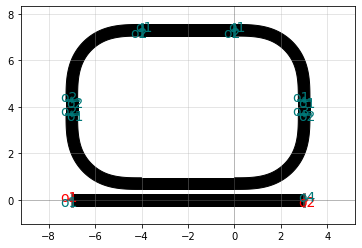

ring_single_f4d868f6: uid 19, ports ['o2', 'o1'], aliases [], 0 polygons, 6 references

In [3]:
ring_single3 = gf.partial(ring_single, radius=3)
ring_single3()

### Circuit netlist

Sometimes, when a component is mostly composed of sub-components adjacent to each
other, it can be easier to define the component by sub-component connections and by which ports are part of the new components.

This can be done using a netlist based approach where these 3 parts are defined:

- components: a dictionary of `{component reference name: (component, transform)}`
- connections: a list of `(component ref name 1, port name A, component ref name 2, port name B)`
- ports_map: a dictionary of which ports are being exposed together with their new name `{port_name: (component ref name, port name)}`

The code below illustrates how a simple MZI can be formed using this method.

2022-03-03 06:45:38.899 | INFO     | gdsfactory.show:show:36 - Klayout show simple_mzi: uid 46, ports [], aliases [], 0 polygons, 14 references


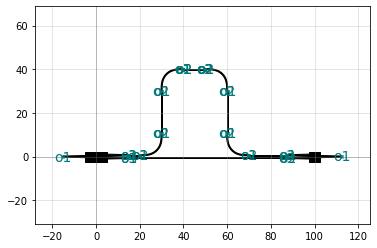

In [4]:
import gdsfactory as gf

yaml = """
name: simple_mzi
instances:
    mmi1:
      component: mmi1x2
      settings:
        width_mmi: 4.5
        length_mmi: 10
    mmi2:
      component: mmi1x2
      settings:
        width_mmi: 4.5
        length_mmi: 5
    
    straight:
        component: straight

placements:
    mmi2:
        x: 100
        mirror: True
    
    straight:
        x: 40
        y: 40

routes:
    route_name1:
        links:
            mmi1,o3: mmi2,o3
    route_name2:
        links:
            mmi1,o2: straight,o1
    route_name3:
        links:
            mmi2,o2: straight,o2

"""

mzi = gf.read.from_yaml(yaml)
mzi.show()
mzi.plot()

Exporting connectivity map from a GDS is the first step towards verification.

- Adding ports to *every* cells in the GDS
- Generating the netlist


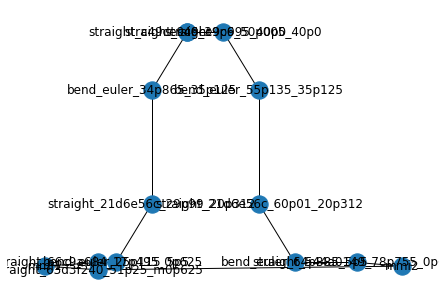

In [5]:
mzi.plot_netlist()

## Mask

Once you have your components and circuits defined, you can add them into a mask that you will send to the foundry for fabrication.

You will need to consider:

- what design variations do you want to include in the mask? You need to define your Design Of Experiment or DOE
- obey DRC (Design rule checking) foundry rules for manufacturability. Foundry usually provides those rules for each layer (min width, min space, min density, max density)
- make sure you will be able to test te devices after fabriation. Obey DFT (design for testing) rules. For exammple, if your test setup works only for fiber array, what is the fiber array spacing (127 or 250um?)
- if you plan to package your device, make sure you follow your packaging guidelines from your packaging house (min pad size, min pad pitch, max number of rows for wire bonding ...)

2022-03-03 06:45:39.374 | INFO     | gdsfactory.show:show:36 - Klayout show mask: uid 84, ports [], aliases [], 0 polygons, 2 references


mask: uid 84, ports [], aliases [], 0 polygons, 2 references


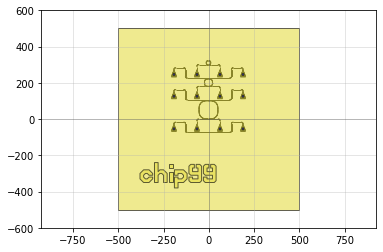

mask: uid 84, ports [], aliases [], 0 polygons, 2 references

In [6]:
import toolz
import gdsfactory as gf

ring_te = toolz.compose(gf.routing.add_fiber_array, gf.components.ring_single)
rings = gf.grid([ring_te(radius=r) for r in [10, 20, 50]])


@gf.cell
def mask(size=(1000, 1000)):
    c = gf.Component()
    c << gf.components.die(size=size)
    c << rings
    return c


m = mask(cache=False)
m

In [7]:
gdspath = m.write_gds_with_metadata(gdspath="mask.gds")

2022-03-03 06:45:39.546 | INFO     | gdsfactory.component:write_gds:873 - Write GDS to 'mask.gds'


2022-03-03 06:45:39.775 | INFO     | gdsfactory.component:write_gds_with_metadata:881 - Write YAML metadata to 'mask.yml'


Make sure you save the GDS with metadata so when the chip comes back you remember what you put on it

You can also save the labels for automatic testing.

In [8]:
labels_path = gdspath.with_suffix('.csv')
gf.mask.write_labels(gdspath=gdspath, layer_label=(66, 0))

2022-03-03 06:45:39.784 | INFO     | gdsfactory.mask.write_labels:write_labels:61 - Wrote 12 labels in /home/runner/work/gdsfactory/gdsfactory/docs/notebooks/mask.csv


PosixPath('mask.csv')

In [9]:
mask_metadata =gf.mask.read_metadata(gdspath=gdspath)
tm = gf.mask.merge_test_metadata(mask_metadata=mask_metadata, labels_path=labels_path)

In [10]:
tm.keys()

dict_keys(['ring_single', 'ring_single_d8d11220', 'ring_single_803a01be'])